In [ ]:
import math
import random
import csv
import sys
import operator
import pickle
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from shapely.geometry import Polygon, Point

import cvxpy as cp

import keras
from keras import layers
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.special import comb, perm
import time

In [ ]:
!pip install Ipython --upgrade
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Mount Google Drive Folder

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')
rootPath = '/content/drive/Shareddrives/KW phase1 repo'

Mounted at /content/drive


In [ ]:
import sys
sys.path.append(rootPath+'/package')
from utils.env_mj import env
from model.uav import UAV

## AE 

### Read Rawdata from csv



In [ ]:
socpResultsDatas = []
div = 10
for j in range(env.N_ngps):
  with open(rootPath+"/datas/anomalySDPResult/done0808_3/test_position{}_pickerror0_deviation{}_300.csv".format(j,div), "r") as _csv:
    csvReader = list (csv.reader(_csv, delimiter=',', quoting=csv.QUOTE_NONNUMERIC))
    socpResultsDatas.append(csvReader)

### Read UAV Position

In [ ]:
f = open(rootPath+"/datas/uavPosition/300_0706/done_deviation/{}/UAVsSamples.pkl".format(div), "rb")
UAVsSamples = pickle.load(f)
print(UAVsSamples)

{0: {0: <model.uav.UAV object at 0x7fe7e5f91850>, 1: <model.uav.UAV object at 0x7fe7e5f91650>, 2: <model.uav.UAV object at 0x7fe7e5f91790>, 3: <model.uav.UAV object at 0x7fe7e5f91590>, 4: <model.uav.UAV object at 0x7fe7e5f91910>, 5: <model.uav.UAV object at 0x7fe7e5f917d0>, 6: <model.uav.UAV object at 0x7fe7e5f91250>, 7: <model.uav.UAV object at 0x7fe7e5f913d0>, 8: <model.uav.UAV object at 0x7fe798a4ffd0>, 9: <model.uav.UAV object at 0x7fe802ddeed0>, 10: <model.uav.UAV object at 0x7fe802dde450>, 11: <model.uav.UAV object at 0x7fe802dde490>, 12: <model.uav.UAV object at 0x7fe802ddeb50>, 13: <model.uav.UAV object at 0x7fe802ddef50>, 14: <model.uav.UAV object at 0x7fe802dde2d0>, 15: <model.uav.UAV object at 0x7fe802ddec50>}, 1: {0: <model.uav.UAV object at 0x7fe802dde310>, 1: <model.uav.UAV object at 0x7fe802dde410>, 2: <model.uav.UAV object at 0x7fe802dde510>, 3: <model.uav.UAV object at 0x7fe7e5f912d0>, 4: <model.uav.UAV object at 0x7fe7e5f74890>, 5: <model.uav.UAV object at 0x7fe7e5ec1

In [ ]:
assert(np.array(socpResultsDatas).shape[0] == env.N_ngps)
assert(np.array(socpResultsDatas).shape[2] == env.DIMENSION)
groupSize =0
for i in np.arange(env.DIMENSION+2,env.N_ngps+1,1):
  groupSize += comb(env.N_ngps,i)
groupSize = int(groupSize)
print(np.array(socpResultsDatas).shape[1]//env.SAMPLES)
# assert(np.array(socpResultsDatas).shape[1]//env.SAMPLES == groupSize)

93


### Loading sample from data

In [ ]:
rawDatas = []
ReadSampleSize = env.LOAD_SAMPLES_FOR_AE
for i in range(env.N_ngps):
  temp = []
  for j in range(ReadSampleSize):
    temp.append(socpResultsDatas[i][j*groupSize : j*groupSize+groupSize])
  rawDatas.append(temp)

In [ ]:
assert(np.array(rawDatas).shape[1] ==  env.LOAD_SAMPLES_FOR_AE)

In [ ]:
_anchorSamples = []
anchorSamples = []
for sample in range(ReadSampleSize):
  temp = []
  for id, uav in UAVsSamples[sample].items():
    if not uav.observedPosition == None:
      temp.append([uav.observedPosition for i in range(groupSize)])
  _anchorSamples.append(temp)
for i in range(env.N_gps):
  temp = []
  for sample in range(ReadSampleSize):
    temp.append(_anchorSamples[sample][i])
  anchorSamples.append(temp)

In [ ]:
# list(map(lambda i: rawDatas.append(anchorSamples[i]), range(env.N_gps)))
# None
# assert(np.array(rawDatas).shape[0] == env.N)

In [ ]:
np.array(rawDatas).shape

(8, 100, 93, 3)

### Devide Test and Training set


In [ ]:
testingSampleSize = int(( ReadSampleSize * env.TEST_PERCENTAGE )//1)
if testingSampleSize == 0:
  testingSampleSize = 1
traningSampleSize = int(ReadSampleSize-testingSampleSize)
rawTrainingData = list(map( lambda item: item[:-testingSampleSize], rawDatas))
rawTestingData =  list(map( lambda item: item[traningSampleSize:], rawDatas))

In [ ]:
dualGroupingTrainingData = []
dualGroupingTestingData = []
def dualFunc(X,i,j): 
    temp = []
    for index_1, e1 in enumerate(X[i][j]):
      for index_2, e2 in enumerate(X[i][j]):
        if not index_1 == index_2:
          temp.append([e1, e2])
    return temp

rawTrainingDataShape = np.array(rawTrainingData).shape
rawTestingDataShape = np.array(rawTestingData).shape
for i in range(rawTrainingDataShape[0]):
  trainingS = list(map(lambda j: dualFunc(rawTrainingData,i,j),np.arange(0,rawTrainingDataShape[1])))
  testingS = list(map(lambda j: dualFunc(rawTestingData,i,j),np.arange(0,rawTestingDataShape[1])))
  dualGroupingTrainingData.append(trainingS)
  dualGroupingTestingData.append(testingS)

_trainingDataShape = np.array(dualGroupingTrainingData).shape
_testingDataShape= np.array(dualGroupingTestingData).shape
_reshapeTrainingData = []
_reshapeTestingData = []
def swapFunc(j,X,shapeOfX,targetReformSlice): 
  for sample in range(shapeOfX[1]): #sample
    temp = []
    for i in range(shapeOfX[0]):
      temp.append(X[i][sample][j])
    targetReformSlice.append(temp) 
list(map(lambda _sample: swapFunc(_sample,dualGroupingTrainingData,_trainingDataShape,_reshapeTrainingData), range(_trainingDataShape[2]))) #8556
list(map(lambda _sample: swapFunc(_sample,dualGroupingTestingData,_testingDataShape,_reshapeTestingData), range(_testingDataShape[2])))
print("")
VAETrainingData = np.array(_reshapeTrainingData).reshape(len(_reshapeTrainingData), np.prod(np.array(_reshapeTrainingData).shape[1:]))
VAETestingData = np.array(_reshapeTestingData).reshape(len(_reshapeTestingData), np.prod(np.array(_reshapeTestingData).shape[1:]))

In [ ]:
shapeOfRawTrainingData = np.array(rawTrainingData).shape
assert(np.array(VAETrainingData).shape[1] == shapeOfRawTrainingData[0]*shapeOfRawTrainingData[3]*2)
assert(np.array(VAETestingData).shape[1] == shapeOfRawTrainingData[0]*shapeOfRawTrainingData[3]*2)

### normorlization


In [ ]:
data_min = 0
data_max = max(max(env.X_RANGE,env.Y_RANGE),env.Z_RANGE)
print(data_min, data_max)

normalizeVAETrainingData = (VAETrainingData-data_min)/(data_max - data_min)
normalizeVAETrainingData = normalizeVAETrainingData.astype('float32')

normalizeVAETestingData = (VAETestingData-data_min)/(data_max - data_min)
normalizeVAETestingData = normalizeVAETestingData.astype('float32')

0 1000


In [ ]:
X_train = normalizeVAETrainingData
y_train = normalizeVAETestingData

In [ ]:
print(np.array(X_train).shape)
print(np.array(y_train).shape)

(770040, 48)
(85560, 48)


In [ ]:
print(_reshapeTrainingData[0])
print(normalizeVAETrainingData[0])

[[[407.2279545742377, 413.1450144653529, 454.85019984091207], [401.2568068018953, 418.16813007059864, 453.49181333088524]], [[693.622051986043, 375.49816884661783, 579.4269336093276], [690.0974473082769, 384.2414769023023, 579.2464682562792]], [[546.8123702750175, 612.6415125491812, 229.05045669618667], [543.7848525620615, 617.6110315861945, 226.3833253404697]], [[815.3555060261579, 826.6151876606729, 381.2815120848857], [809.8237107329392, 838.9694651714078, 378.7844314916631]], [[571.7450910396266, 763.1202052791459, 591.156506313093], [574.2912302133628, 770.6964592071294, 596.2055546622576]], [[606.6168761312603, 376.57542639851476, 222.41302789571168], [610.8517240880228, 371.904736168644, 219.62302989122114]], [[748.2757193792573, 694.2546537980501, 521.4929029098639], [758.2145515703633, 697.2307020101933, 515.1589913883147]], [[421.1274058453393, 372.835786708974, 379.7182836760551], [421.1729713106156, 366.73921435051255, 381.1956624426828]]]
[0.40722796 0.413145   0.4548502  

In [ ]:
batch_size = env.batch_size
latent_dim = env.latent_dim
intermediate_dim =env.intermediate_dim
final_dim = env.final_dim
epochs = env.epochs
epsilon_std = env.epsilon_std

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
originalShape = X_train.shape[1:]
originalDimaintion = np.prod(originalShape)
print(originalShape)
in_layer = Input(shape=originalShape)
x = Flatten()(in_layer)
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(final_dim, activation = 'relu')(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_f = Dense(final_dim, activation='relu')
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(originalDimaintion, activation='sigmoid')

f_decoded = decoder_f(z)
h_decoded = decoder_h(f_decoded)
x_decoded_mean = decoder_mean(h_decoded)
x_decoded_img = Reshape(originalShape)(x_decoded_mean)

# instantiate VAE model
vae = Model(in_layer, x_decoded_img)

# Compute VAE loss
xent_loss = originalDimaintion * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.summary()

(48,)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 48)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           3136        flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        dense[0][0]                      
________________________________________________________________________________________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = vae.fit(X_train, X_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        shuffle=True,
        validation_data=(y_train, y_train),
        callbacks=[callback],
        ).history

Epoch 1/100
94/94 [==============================] - 16s 32ms/step - loss: 36.3397 - val_loss: 34.7140
Epoch 2/100
94/94 [==============================] - 3s 27ms/step - loss: 34.1231 - val_loss: 33.8615
Epoch 3/100
94/94 [==============================] - 2s 27ms/step - loss: 33.6001 - val_loss: 33.5656
Epoch 4/100
94/94 [==============================] - 2s 26ms/step - loss: 33.4154 - val_loss: 33.4349
Epoch 5/100
94/94 [==============================] - 2s 27ms/step - loss: 33.3285 - val_loss: 33.3659
Epoch 6/100
94/94 [==============================] - 3s 27ms/step - loss: 33.2790 - val_loss: 33.3212
Epoch 7/100
94/94 [==============================] - 3s 27ms/step - loss: 33.2494 - val_loss: 33.2896
Epoch 8/100
94/94 [==============================] - 3s 27ms/step - loss: 33.2238 - val_loss: 33.2686
Epoch 9/100
94/94 [==============================] - 3s 27ms/step - loss: 33.2090 - val_loss: 33.2561
Epoch 10/100
94/94 [==============================] - 3s 27ms/step - loss: 33.194

In [ ]:
vae.save(rootPath+"/datas/trainingModel/V2_VAENoanchorModel_300sample_8UAV_8uUAV_div{}_".format(div)+str(round(time.time() * 1000)))

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/KW phase1 repo/datas/trainingModel/V2_VAENoanchorModel_300sample_8UAV_8uUAV_div10_1628563894181/assets


In [ ]:
# modelPath = rootPath+"/datas/trainingModel/VAENoanchorModel_300sample_8UAV_8uUAV_div20"
# loadVae = keras.models.load_model(modelPath, custom_objects={'latent_dim': env.latent_dim, 'epsilon_std': env.epsilon_std})

In [ ]:
# vae = loadVae

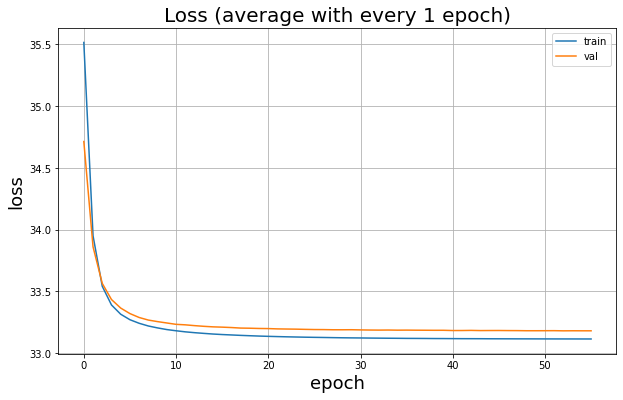

In [ ]:
fig = plt.figure(figsize=(10,6))
acc = []
valAcc = []
step = 1
for i in range(len(history['loss'])//step):
  acc.append(np.mean(history['loss'][i:i+step:1]))
  valAcc.append(np.mean(history['val_loss'][i:i+step:1]))

plt.plot(acc)
plt.plot(valAcc)
plt.title('Loss (average with every {} epoch)'.format(step), fontsize=20)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.grid()
plt.legend(['train', 'val'], loc='upper right')

In [ ]:
from model.sdp import SDP 
from service.distributeuavs import distributeUAVs
from model.pathlossmodel import PathLossModel, NoiseMaker
from service.combinationset import generateCombination
UAVs = distributeUAVs()
uavIndexes_withoutGPS = np.random.choice(env.N, env.N_ngps, replace=False)
for id in uavIndexes_withoutGPS:
  UAVs[id].observedPosition = None

uavList_gps = []
for id, uav in UAVs.items():
  if not uav.observedPosition == None:
    uavList_gps.append(id)

print(uavList_gps)
anomaly_index = np.random.choice(uavList_gps, 1, replace=False)[0]
print(anomaly_index)

originObservedPosition = UAVs[anomaly_index].observedPosition
print(originObservedPosition)
shift = np.random.choice(np.arange(500, 1000), 3, replace=False)
print(shift)
newObservedPosition = [originObservedPosition[0]+shift[0], originObservedPosition[1]+shift[1], originObservedPosition[2]+shift[2]]
print(newObservedPosition)
UAVs[anomaly_index].observedPosition = newObservedPosition
pathLossModel = PathLossModel()
pathLossModel.noiseMaker = NoiseMaker(mean = env.noiseMean, deviation = env.noiseDeviation)
for i, uav_i in UAVs.items():
  for j, uav_j in UAVs.items():
    if not i == j:      
      realDistance_ij = np.linalg.norm(np.array(uav_i.realPosition) - np.array(uav_j.realPosition))
      rss = pathLossModel.estimateRSS(uav_i.power, realDistance_ij)
      uav_i.collectRSS(j, rss)

groupList = []
for groupSize in range(env.DIMENSION+2, env.N_gps+1):
  groupList.append(generateCombination(UAVs, groupSize))

sdp = SDP()
sdp.var_SOCPt = cp.Variable(1)
sdp.var_SDPt = cp.Variable(1)
sdp.var_p = [cp.Variable((env.DIMENSION+1, env.DIMENSION+1), symmetric=True) for i in range(env.N_ngps)]

targets = []
for uavIndex, uav in UAVs.items():
  if uav.observedPosition is None:
    targets.append(uav)

results = []
for groups in groupList:
  for group in groups:
    print(".", end='')
    anchors = []
    for i in group:
      anchors.append(UAVs[i])

    sdp.buildConstraint(targets, anchors, pathLossModel)
    sdp.doSolve(log=False)
    results.append([sdp.var_p[i].value[-1][:3] for i in range(env.N_ngps)])

print(np.array(results).shape)
sdpResult_uav = []
for i in range(np.array(results).shape[1]):
  temp = []
  for j in range(np.array(results).shape[0]):
    temp.append(results[j][i])
  sdpResult_uav.append(temp)
print(np.array(sdpResult_uav).shape)
h = int (np.array(sdpResult_uav).shape[1])
print(h)

X = []
for i in range(env.N_ngps):
  temp = []
  temp.append(sdpResult_uav[i][0 : h])
  X.append(temp)
print(np.array(X).shape)


print(np.array(X).shape)

new_X = []
for i in range(np.array(X).shape[0]):
  s = []
  for j in range(np.array(X).shape[1]):
    temp = []
    for index_1, e1 in enumerate(X[i][j]):
      for index_2, e2 in enumerate(X[i][j]):
        if not index_1 == index_2:
          temp.append([e1, e2])
    s.append(temp)
  new_X.append(s)

X_reform = []
rangeSample = range(np.array(new_X).shape[1])

def swapFunc(j):
  # print(j)
  for sample in rangeSample:
    temp = []
    for i in range(np.array(X).shape[0]):
      temp.append(new_X[i][sample][j])
    X_reform.append(temp)

nothing = list (map(lambda x: swapFunc(x), range(np.array(new_X).shape[2])))
print(np.array(X_reform).shape)

data = np.array(X_reform).reshape(len(X_reform), np.prod(np.array(X_reform).shape[1:]))
data_min =0
data_max = 1000
anomaly_data = (data-data_min)/(data_max - data_min)

[1, 3, 4, 6, 8, 11, 14, 15]
15
[917.0, 106.0, 665.0]
[817 734 515]
[1734.0, 840.0, 1180.0]
.............................................................................................(93, 8, 3)
(8, 93, 3)
93
(8, 1, 93, 3)
(8, 1, 93, 3)
(8556, 8, 2, 3)


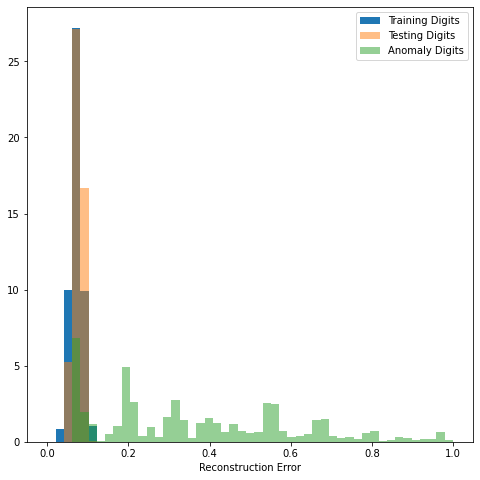

In [ ]:
model_mse = lambda x: np.mean(np.square(x-vae.predict(x, batch_size = batch_size)), axis=1)
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(model_mse(X_train), bins = np.linspace(0, 1, 50), label = 'Training Digits', density = True, alpha = 1.0)
ax1.hist(model_mse(y_train), bins = np.linspace(0, 1, 50), label = 'Testing Digits', density = True, alpha = 0.5)
ax1.hist(model_mse(anomaly_data), bins = np.linspace(0, 1, 50), label = 'Anomaly Digits', density = True, alpha = 0.5)
ax1.legend()
ax1.set_xlabel('Reconstruction Error');

In [ ]:
trainMean = np.mean(model_mse(X_train))
trainStd = np.std(model_mse(X_train))
testMean = np.mean(model_mse(y_train))
testStd = np.std(model_mse(y_train))
anomalyMean = np.mean(model_mse(anomaly_data))
anomalyStd = np.std(model_mse(anomaly_data))
print(trainMean,testMean,anomalyMean)
print(trainStd,testStd,anomalyStd)
# print(model_mse(X_train).shape)

0.07178666 0.07819041 28.629298972272718
0.013869818 0.010916955 179.84443454036037


## old diveration

In [ ]:
# 300 0704v1:
# 0.07436927 0.07699597 0.054998312270594325
# 0.019676328 0.013380986 0.0009726283651491706

# 300 done0707 div100:
# 0.15648374 0.15397678 0.196678508225165
# 0.9196566 0.7651025 0.09755577523374563

# 300 done0706 div50:
# 0.09351211 0.08851162 0.3115592645430587
# 0.18807583 0.24388546 0.36745009009565793

# 300 done0706 div40:
# 0.081393935 0.07820652 0.26502518039982365
# 0.05719767 0.022991301 0.2959898250948463


# 300 done0706 div30:
# 0.0744761 0.07594628 0.48762657351931915
# 0.037996132 0.012782744 0.5052127902962636

# 300 done0706 div20:
# 0.074475974 0.07594658 0.2863796816028362
# 0.037996143 0.012783654 0.34895287927333374

# 300 done0706 div10:
# 0.07432603 0.079801805 0.2830321424288249
# 0.038715895 0.010871667 0.34954340771656495

# 300 done0706 div8:
# 0.075449705 0.074284256 0.5867427150738699
# 0.015290236 0.012488764 1.0826241506795675

# 300 done0706 div6:
# 0.075734876 0.07877102 0.6234568755158325
# 0.072299294 0.009542763 0.8020210554058497

# 300 done0706 div4:
# 0.07619274 0.0722503 0.6210804269395847
# 0.013823844 0.011295614 0.7999796252351657

# 300 done0706 div2:
# 0.076432616 0.07152502 0.3297432089072659
# 0.013498285 0.013109973 0.615774765489737

# 300 done0706 div1:
# 0.07977445 0.06907099 0.19485387283010253
# 0.015412254 0.012532986 0.11821419450675921


## new deviation

In [ ]:
# 100 0806 div_50
# 0.06622 0.07911093 0.16701182831119277
# 0.035157412 0.20487624 0.1601530255153914

# 100 0806 div_40
# 0.06598053 0.06790833 0.21256275933818167
# 0.020248828 0.015070292 0.13334003722903393

# 100 0806 div_30
# 0.066320375 0.06644754 0.5090600152225242
# 0.023091335 0.017682184 0.4570613597203265

In [ ]:
def KL(a, b):
    size = min(len(a),len(b))
    a = np.asarray(a[:size], dtype=np.float)
    b = np.asarray(b[:size], dtype=np.float)
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

print(KL(model_mse(X_train),model_mse(y_train)))
print(KL(model_mse(X_train),model_mse(anomaly_data)))


-351.6387184036483
-1378.078246131731


In [ ]:
data_pred = vae.predict(X_train)
reshapePredictResult = data_pred.reshape([data_pred.shape[0],shapeOfRawTrainingData[0],2,shapeOfRawTrainingData[3]])
reshapePredictResult = (np.mean(reshapePredictResult,axis=2)*1000).reshape((reshapePredictResult.shape[0],shapeOfRawTrainingData[0],shapeOfRawTrainingData[3]))

In [ ]:
reshapetraining = X_train.reshape([X_train.shape[0],shapeOfRawTrainingData[0],2,shapeOfRawTrainingData[3]])
reshapetraining = (np.mean(reshapetraining,axis=2)*1000).reshape((reshapetraining.shape[0],shapeOfRawTrainingData[0],shapeOfRawTrainingData[3]))

In [ ]:
predictAnomalyData = vae.predict(anomaly_data)
reshapepredictAnomalyDataResult = predictAnomalyData.reshape([predictAnomalyData.shape[0],shapeOfRawTrainingData[0],2,shapeOfRawTrainingData[3]])
reshapepredictAnomalyDataResult = (np.mean(reshapepredictAnomalyDataResult,axis=2)*1000).reshape((predictAnomalyData.shape[0],shapeOfRawTrainingData[0],shapeOfRawTrainingData[3]))

In [ ]:
priorPoints = np.mean(reshapetraining,axis=0).reshape((8,3))
predictPoints = np.mean(reshapePredictResult,axis=0).reshape((8,3))
anomalyPoints = np.mean(reshapepredictAnomalyDataResult,axis=0).reshape((8,3))

0 [531.0, 615.0, 436.0]
7 [617.0, 841.0, 806.0]
2 [773.0, 126.0, 141.0]
7 [843.0, 115.0, 588.0]
7 [872.0, 513.0, 960.0]
5 [758.0, 336.0, 827.0]
7 [763.0, 470.0, 596.0]
7 [344.0, 687.0, 119.0]


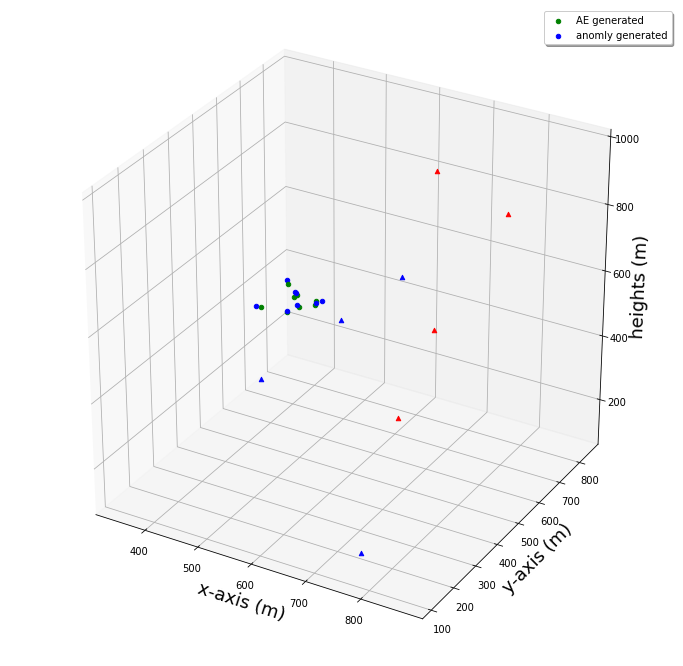

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.set_xlabel('x-axis (m)', fontsize=18)
ax.set_ylabel('y-axis (m)', fontsize=18)
ax.set_zlabel('heights (m)', fontsize=18)
plt.grid()
for iUAV, position in enumerate(priorPoints):
  x = position[0]
  y = position[1]
  z = position[2]
  if UAVs[iUAV].observedPosition != None:
    scatter1 = ax.scatter(UAVs[iUAV].realPosition[0], UAVs[iUAV].realPosition[1], UAVs[iUAV].realPosition[2], c='r', marker='^')
    print(i,UAVs[iUAV].realPosition)
  elif UAVs[iUAV].observedPosition == None:
    scatter2 = ax.scatter(UAVs[iUAV].realPosition[0], UAVs[iUAV].realPosition[1], UAVs[iUAV].realPosition[2], c='b', marker='^')
    print(iUAV,UAVs[iUAV].realPosition)

for position in predictPoints:
  x = position[0]
  y = position[1]
  z = position[2]
  scatter3 = ax.scatter(x, y, z, c='g', marker='o')

for position in anomalyPoints:
  x = position[0]
  y = position[1]
  z = position[2]
  scatter4 = ax.scatter(x, y, z, c='b', marker='o')

# plt.legend([scatter1, scatter2, scatter3,scatter4], [ 'anchor','sdp estimated', 'AE generated', 'anomly generated'], loc='upper right', shadow=True)
plt.legend([scatter3,scatter4], [ 'AE generated', 'anomly generated'], loc='upper right', shadow=True)

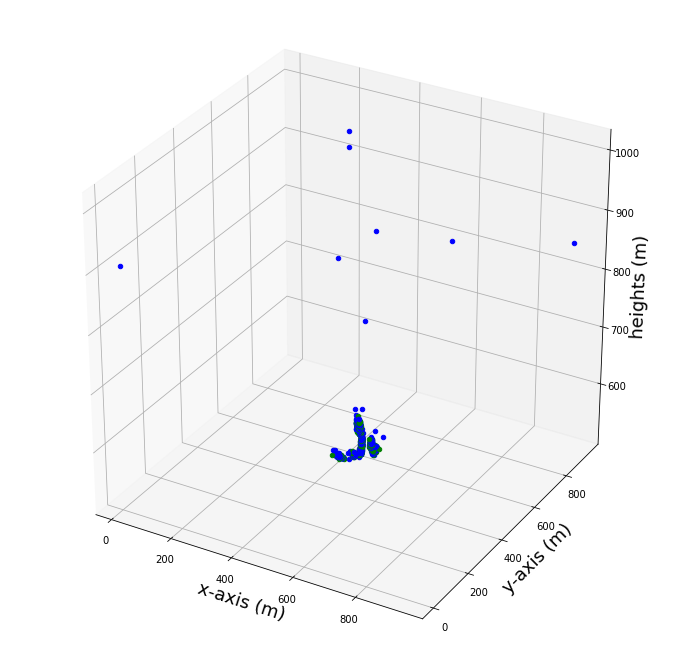

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.set_xlabel('x-axis (m)', fontsize=18)
ax.set_ylabel('y-axis (m)', fontsize=18)
ax.set_zlabel('heights (m)', fontsize=18)
plt.grid()
for isample,positions in enumerate(reshapePredictResult[:100]):
  for position in positions:
    x = position[0]
    y = position[1]
    z = position[2]
    scatter3 = ax.scatter(x, y, z, c='g', marker='o')
for isample,positions in enumerate(reshapepredictAnomalyDataResult[:100]):
  for position in positions:
    x = position[0]
    y = position[1]
    z = position[2]
    scatter4 = ax.scatter(x, y, z, c='b', marker='o')

# plt.legend([scatter1, scatter2, scatter3,scatter4], [ 'anchor','sdp estimated', 'AE generated', 'anomly generated'], loc='upper right', shadow=True)
# plt.legend([scatter3,scatter4], [ 'AE generated', 'anomly generated'], loc='upper right', shadow=True)